# Projekt

## Zielsetzung und Datenverständnis

In diesem Projekt wendet ihr selbst alle Konzepte aus den vorherigen Notebooks auf einen echten Datensatz an. Ziel ist es, mithilfe der bisher erlernten Methoden ein maschinelles Lernmodell zu entwickeln, das auf Basis physikalischer und materialtechnischer Eigenschaften vorhersagen kann, ob ein bestimmtes Ereignis eintritt. Darüber hinaus werden wir nicht nur vorhersagen können, **ob** ein Ereignis eintritt, sondern auch **wann** dies voraussichtlich geschieht.
Dabei werdet ihr vom Preprocessing, über Visualisierung und Feature-Engineering bis hin zur Evaluation eures fertigen Modells alles bisher Gelerntes anwenden und vertiefen.

### Anmerkungen zur Bewertung/Benotung

TODO

### Der Kontext

Steckverbindungen sind essenzielle Bauteile in vielen technischen Systemen – von der Automobilindustrie bis zur Elektronikfertigung. Mit der Zeit und unter Belastung (z. B. durch Vibration oder Temperaturwechsel) kann der elektrische Kontaktwiderstand steigen. Überschreitet er einen bestimmten Schwellenwert (meist 300 mΩ), gilt die Verbindung typischerweise als defekt.

Der vorliegende Datensatz enthält Informationen zu mehreren Steckverbindungen, die einem Experiment unterzogen wurden, in dem Steckvorgänge zyklisch simuliert wurden. Darunter findet ihr:

* **Materialeigenschaften** wie die Art der Beschichtung (Silber, Zinn) oder das Vorhandensein einer Zwischenschicht (Nickel),
* **Prozessparameter** wie Normalkraft, Frequenz und Bewegungshub,
* sowie die **Zyklenzahl**, bei der ein bestimmter Widerstandsschwellenwert (z. B. 1 mΩ, 20 mΩ, …, 300 mΩ) erstmals überschritten wurde – falls überhaupt.

Im Experiment wurden die Steckverbindungen unter bekannter Normalkraft, Frequenz und Hub zyklisch der Steckbelastung (Einstecken und Ausstecken) unterzogen. Die Zyklenanzahl war vorher fest definiert und richtete sich nach der durchschnittlich zu erwartenden Zahl an Steckvorgängen, die im Leben einer Steckverbindung zu erwarten ist. Eine Überschreitung des Schwellenwerts von 300 mΩ während des Experiments heißt also, dass diese Verbindung in der Realität ebenfalls wahrscheinlich defekt geworden wäre. Wir wollen diese Daten nun folgendermaßen nutzen:

### Das Ziel

Ihr werdet ein **zweistufiges Modell** entwickeln:

1. **Klassifikation**:
   Vorhersage, ob eine Steckverbindung **überhaupt** den Schwellenwert von 300 mΩ überschreiten wird, basierend auf rein physikalischen Features.
   → Features: Beschichtung, Zwischenschicht, Normalkraft, Frequenz und Hub
   → Zielgröße: *Ja (1)* oder *Nein (0)*

2. **Regression** (für die vorhergesagten "Ja"-Fälle):
   Schätzung, **nach wie vielen Belastungszyklen** der Widerstand von 300 mΩ erreicht wird, basierend auf der gemessenen Zyklenanzahl während des Experiments.
   → Features: Zyklus_bei_1mOhm, Zyklus_bei_2mOhm, Zyklus_bei_5mOhm, ..., Zyklus_bei_300mOhm
   → Zielgröße: *Zyklenanzahl*

Diese Kombination ermöglicht es, zunächst risikobehaftete Steckverbindungen zu identifizieren und anschließend genauer abzuschätzen, wann voraussichtlich ein kritischer Zustand eintritt, um gezielt Wartungsarbeiten einzuleiten.

### Der Datensatz

Die Datei `Schwellenwerte-Table 1.csv` enthält pro Zeile eine Steckverbindung mit:

* einem **Dateinamen** (`Datei`)
* Angaben zu **Material und Prozessparametern**
* Zyklenzahlen, bei denen bestimmte **Ohm-Schwellen überschritten wurden** (z. B. `Zyklus_bei_300_mOhm`)

  * Ein Wert von **-1** bedeutet: Schwelle wurde **nicht** überschritten.

## Aufgabe 1: Überblick verschaffen

Lade die Datei `Schwellenwerte-Table 1.csv` mit `pandas` ein und speichere die Daten in einem DataFrame namens `df`. Verschaffe dir einen Überblick:

* Gib die Form des DataFrames mit `.shape` aus
* Zeige die ersten 5 Zeilen mit `.head()`
* Liste die Spaltennamen auf
* Gib eine Übersicht der statistischen Kenngrößen aus (max, min, std, mean, ...)

In [1]:
### Importiere pandas
import pandas as pd

# Lade die CSV-Datei in einen DataFrame
df = pd.read_csv('../Data/Schwellenwerte-Table 1.csv')

# Zeige die Form des DataFrames, die ersten 5 Zeilen, die Spaltennamen und eine Übersicht der statistischen Kenngrößen an
print(df.shape)

# Zeige die ersten 5 Zeilen des DataFrames
print(df.head())

# Liste die Spaltennamen auf
print(df.columns)

# Gib eine Übersicht der statistischen Kenngrößen aus
print(df.describe())


(136, 14)
                                Datei Beschichtung_Ag_Sn Zwischenschicht_Ni  \
0    AgCu-200µm-1N-75000zyklen-V1.txt               Nein               Nein   
1   AgCu-200µm-2.5N-6100zyklen-V1.txt               Nein               Nein   
2  AgCu-200µm-2.5N-29000zyklen-V1.txt               Nein               Nein   
3     AgCu-200µm-5N-3000zyklen-V1.txt               Nein               Nein   
4    AgCu-200µm-5N-13000zyklen-V1.txt               Nein               Nein   

   Normalkraft  Frequenz  Bewegungshub  Zyklus_bei_1_mOhm  Zyklus_bei_2_mOhm  \
0          1.0       1.0           200                  0                 16   
1          2.5       1.0           200                 -1                 -1   
2          2.5       1.5           200                155                810   
3          5.0       1.0           200                 -1                 -1   
4          5.0       1.0           200                 -1                 -1   

   Zyklus_bei_5_mOhm  Zyklus_bei_1

## Aufgabe 2: Erste Visualisierungen – Muster in den Daten erkennen

Ein gutes Machine-Learning-Modell beginnt mit einem tiefen Verständnis für die Daten. In dieser Aufgabe wirst du verschiedene Visualisierungen erstellen, um ein Gefühl für die Verteilung, Streuung und Struktur der wichtigsten Merkmale im Datensatz zu bekommen.

### Hinweise

* Nutze `matplotlib` oder `seaborn`.
* Alle Plots sollten **sinnvoll beschriftet** sein (Achsen, Titel).
* Du musst an dieser Stelle **noch keine neuen Spalten erstellen**, sondern nur die bestehenden visualisieren.
* Versuche, alle Plots übersichtlich und interpretierbar zu gestalten.

### 2.1: Wie viele Steckverbindungen erreichen die einzelnen Schwellenwerte?

Untersuche für jede Widerstandsschwelle, **wie viele Steckverbindungen diesen Wert im Experiment erreicht haben**.

*Hinweis:* Die Spalten `Zyklus_bei_1_mOhm`, `Zyklus_bei_20_mOhm`, ..., `Zyklus_bei_300_mOhm` geben an, nach wie vielen Zyklen der jeweilige Schwellenwert überschritten wurde. Ein Wert von `-1` bedeutet: **nicht erreicht**.

**Plot:** Erstelle dann ein **Balkendiagramm**, das die Anzahl der Steckverbindungen zeigt, die den Schwellenwert erreicht haben.
* Zähle dafür für jede dieser Spalten, wie viele Steckverbindungen einen gültigen Zyklenwert (≠ –1) enthalten.
* Stelle diese Werte als Balkendiagramm dar.

> Ziel: Ein erster Eindruck zur Verteilung der erreichten Schwellwerte und über das Verhältnis von „defekt“ (300 mOhm erreicht) zu „nicht defekt“.


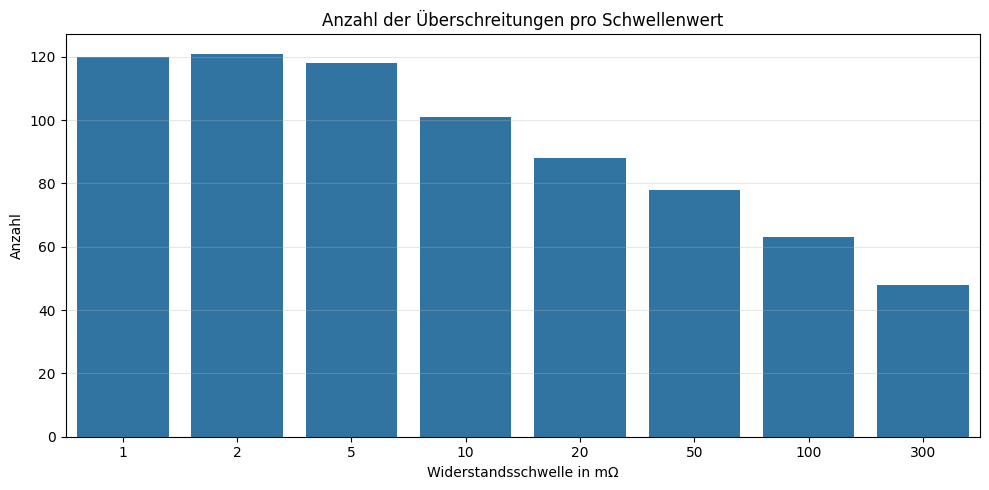

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Alle relevanten Spalten identifizieren
zyklus_cols = [col for col in df.columns if col.startswith("Zyklus_bei")]

# 2. Anzahl der gültigen Werte (≠ -1) pro Spalte zählen
überschreitungen = (df[zyklus_cols] != -1).sum()

# 3. Schwellenwerte extrahieren (z. B. aus 'Zyklus_bei_300_mOhm' → '300')
schwellenwerte = [int(col.replace("Zyklus_bei_", "").replace("_mOhm", "")) for col in überschreitungen.index]

# 5. Plot
plt.figure(figsize=(10, 5))
sns.barplot(x=schwellenwerte, y=überschreitungen)
plt.title("Anzahl der Überschreitungen pro Schwellenwert")
plt.ylabel("Anzahl")
plt.xlabel("Widerstandsschwelle in mΩ")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

### 2.2. Verteilung der numerischen physikalischen Merkmale untersuchen

   Analysiere die Verteilung der zentralen numerischen Eingangsgrößen:

   * `Normalkraft`
   * `Frequenz`
   * `Bewegungshub`

   **Plot:** Erstelle für jede dieser Spalten ein **Histogramm**.

   > Ziel: Gibt es auffällige Ausreißer? Gibt es dominante Wertebereiche? Welche Kombinationen der Features sind am wahrscheinlichsten?

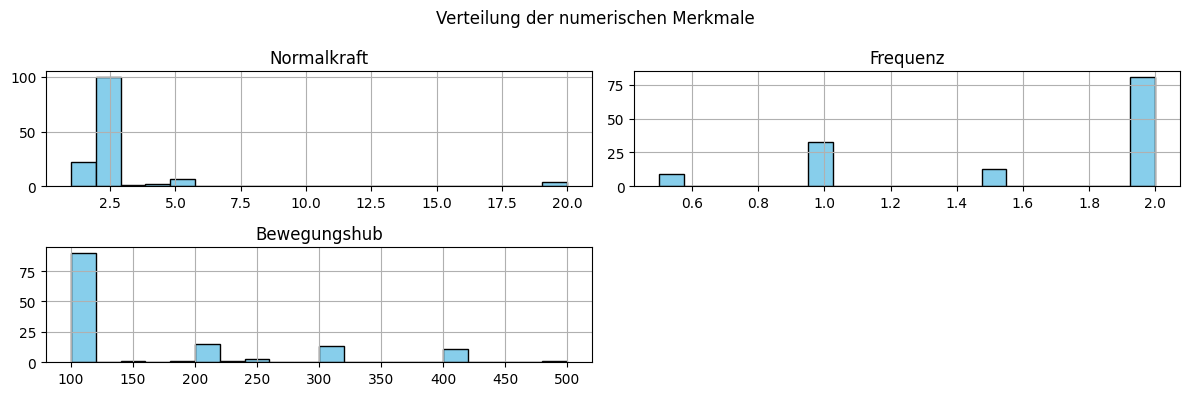

In [3]:
# Liste der numerischen physikalischen Merkmale
numerische_features = ["Normalkraft", "Frequenz", "Bewegungshub"]

# Plot
df[numerische_features].hist(bins=20, figsize=(12, 4), color="skyblue", edgecolor="black")
plt.suptitle("Verteilung der numerischen Merkmale")
plt.tight_layout()
plt.show()

### 2.3. Zyklenanzahlen beim Überschreiten der Schwellenwerte untersuchen

   Die Spalten `Zyklus_bei_1_mOhm`, `Zyklus_bei_20_mOhm`, ..., `Zyklus_bei_300_mOhm` enthalten die Zyklenzahlen, bei denen bestimmte Schwellenwerte überschritten wurden oder `-1`, wenn das nie passiert ist.

   **Schritte:**
   * Erstelle eine Kopie deines DataFrames namens `df_visual`.
   * Ersetze in der Kopie alle `-1`-Werte durch `np.nan`, damit matplotlib/seaborn sie als „fehlend“ behandelt.
   * Erstelle für die obigen Spalten einen **horizontalen Boxplot**, um zu analysieren:

     * Nach wie vielen Zyklen werden die Schwellen erreicht?

     * Wie groß ist die Streuung?

   > Ziel: Ein Gespür für die Streuung und die Zeitpunkte des Ausfalls über verschiedene Widerstandsschwellen hinweg bekommen.

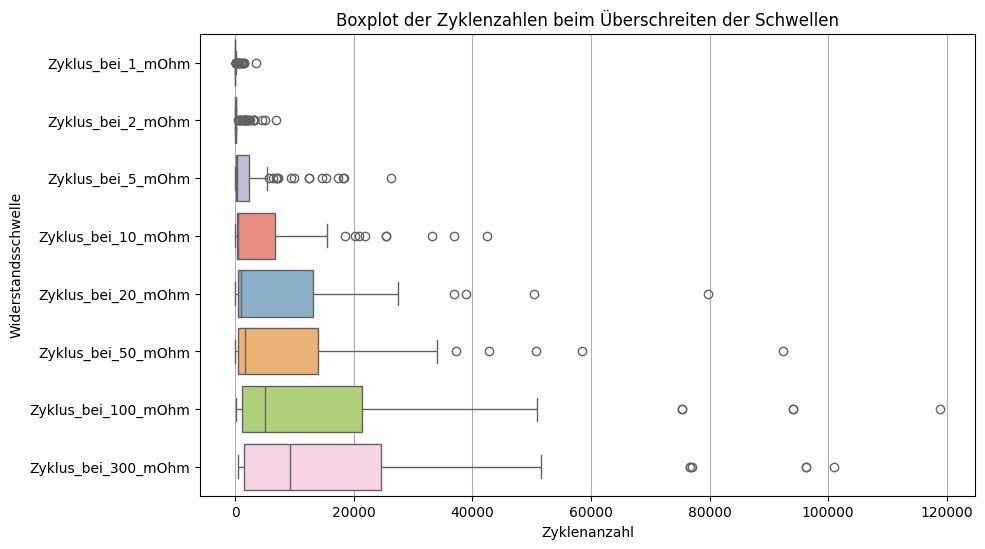

In [4]:
import numpy as np

# Nur die Zyklus-Spalten extrahieren
df_visual = df[zyklus_cols].copy().replace(-1, np.nan)

# Plot
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_visual, orient="h", palette="Set3")
plt.title("Boxplot der Zyklenzahlen beim Überschreiten der Schwellen")
plt.xlabel("Zyklenanzahl")
plt.ylabel("Widerstandsschwelle")
plt.grid(axis="x")
plt.show()


## Aufgabe 3: Preprocessing
In dieser Aufgabe soll der Datensatz sowohl für die Klassifikation als auch für die Regression vorbereitet werden. Ihr werdet entscheiden, wie mit fehlenden Werten umzugehen ist, Zielvariablen erstellen, standardisieren, one-hot-encoden und einen Train-Test-Split erstellen.


### 3.1. Fehlende Werte
* Identifiziert alle Spalten in eurem originalen DataFrame `df`, die fehlende Werte beinhalten. Was sollte mit diesen Datenpunkten geschehen? Entscheidet euch, ob ihr fehlende Werte ersetzt oder Zeilen mit fehlenden Werten ausschließt.

In [5]:
# Untersuche die fehlenden Werte
print(df.isna().sum())

# Droppe die Reihe mit dem fehlenden Wert in der Spalte 'Zyklus_5_mOhm'
df = df.dropna()

Datei                  0
Beschichtung_Ag_Sn     0
Zwischenschicht_Ni     0
Normalkraft            0
Frequenz               0
Bewegungshub           0
Zyklus_bei_1_mOhm      0
Zyklus_bei_2_mOhm      0
Zyklus_bei_5_mOhm      1
Zyklus_bei_10_mOhm     0
Zyklus_bei_20_mOhm     0
Zyklus_bei_50_mOhm     0
Zyklus_bei_100_mOhm    0
Zyklus_bei_300_mOhm    0
dtype: int64


### 3.2. Zielvariablen erstellen

* Für die **Klassifikation** benötigen wir eine Zielspalte, die angibt, _ob_ die 300 mOhm überschritten wurden oder nicht. Erstelle eine Spalte namens `target`, die wie folgt definiert ist:
    * **1**, wenn `Zyklus_300_mOhm` einen Wert größer als 0 enthält
    * **0**, wenn der Wert -1 ist
* Die Klassifikationszielvariable ist erstellt. Für die **Regression** ist die Zielvariable die _Zyklenanzahl_, bei der die 300 mOhm-Schwelle überschritten wird. Um später die Verarbeitung der Spalte `Zyklus_bei_300_mOhm` zu erleichtern, ersetzt alle Einträge `-1` durch `np.nan`.

In [6]:
# Ersetze alle Werte -1 durch np.nan 
df.replace(-1, np.nan, inplace=True)

# Erstelle die Zielvariable für die Klassifikation
df["target"] = (df["Zyklus_bei_300_mOhm"] > 0).astype(int)

### 3.3. Überflüssige Werte?
* Entscheidet euch, ob die Spalte `Datei` für das Training der zwei Modelle relevant ist, oder ob sie ignoriert und gedroppt werden sollte.
* Entscheidet euch, ob die Spalten `Zyklus_bei_1_mOhm` bis `Zyklus_bei_100_mOhm` für das Training der zwei Modelle relevant sind, oder ob sie ignoriert und gedroppt werden sollten.
* Begründet eure Entscheidungen und setzt sie ggf. um.

In [7]:
df.drop(columns=["Datei", "Zyklus_bei_1_mOhm", "Zyklus_bei_2_mOhm", "Zyklus_bei_5_mOhm", "Zyklus_bei_10_mOhm", "Zyklus_bei_20_mOhm", "Zyklus_bei_50_mOhm", "Zyklus_bei_100_mOhm"], inplace=True)

### 3.4. One-Hot-Encoding und Standardisierung
Bereite den Datensatz für das Training der Modelle vor:

1. Wandle **kategorische Variablen** in numerische mit One-Hot-Encoding um. Vermeide Multikollinearität.
2. Standardisiere alle **numerischen Features**, z. B. mit `StandardScaler` von scikit-learn
3. Speichere die verarbeiteten Features in einer neuen Variable `X_processed`. Die Labels sollten in diesem DataFrame nicht mehr vorkommen.

In [8]:
from sklearn.preprocessing import StandardScaler

X = df.drop(columns=["target", "Zyklus_bei_300_mOhm"])  # Zielvariablen entfernen

# One-Hot-Encoding für kategorische Variablen
X_encoded = pd.get_dummies(X, columns=["Beschichtung_Ag_Sn", "Zwischenschicht_Ni"], drop_first=True)

# Standardisierung numerischer Spalten
scaler = StandardScaler()

# Fertige Matrix
X_processed = pd.DataFrame(scaler.fit_transform(X_encoded), columns=X_encoded.columns, index=X_encoded.index)

### 3.5. Daten in Trainings- und Testmenge aufteilen

Teile die Features und Labels in Trainings- und Testdaten auf. Erstelle dafür einen DataFrame `y`, der nur die Zielspalten enthält und benutze `train-test-split` aus sklearn.

Anforderungen:
* 80 % Training, 20 % Test
* Speichere die Arrays als:
  - `X_train`, `X_test`
  - `y_train`, `y_test`
* Setze `random_state=42` für Reproduzierbarkeit

In [9]:
from sklearn.model_selection import train_test_split

target_cols = ["target", "Zyklus_bei_300_mOhm"]
y = df[target_cols]
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, test_size=0.2, random_state=40
)

In [10]:
from scripts.checker import check_preprocessing_pipeline
check_preprocessing_pipeline(
    df=df,
    X_processed=X_processed,
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test
)

✅ Alle echten NaNs entfernt und -1 korrekt durch NaN ersetzt.
✅ Zielvariable korrekt erstellt.
✅ One-Hot-Encoding korrekt angewendet.

 Berechnete Mittelwerte und Standardabweichungen: 

Mittelwerte: 
 Normalkraft     6.579099e-18
Frequenz        3.947460e-17
Bewegungshub   -2.631640e-17
dtype: float64
Standardabweichungen: 
 Normalkraft     1.0
Frequenz        1.0
Bewegungshub    1.0
dtype: float64 

✅ Numerische Features korrekt standardisiert.
✅ Train-Test-Split korrekt!

 Alle Preprocessing-Schritte erfolgreich durchgeführt!


## Aufgabe 4: Logistisches Regressionsmodell trainieren

Trainiere ein logistisches Regressionsmodell auf den Trainingsdaten.

Anforderungen:
* Verwende `LogisticRegression` aus `sklearn.linear_model`
* Speichere das Modell in einer Variable `model`
* Trainiere das Modell mit den Features und der Klassifikationszielvariable.

In [11]:
from sklearn.linear_model import LogisticRegression

y_train_logreg = y_train["target"]


model = LogisticRegression()
model.fit(X_train, y_train_logreg)


LogisticRegression()

In [12]:
from scripts.checker import check_model_training
check_model_training(model, X_train, y_train_logreg)

⚠️ Modell wurde trainiert, aber die Koeffizienten weichen deutlich von der Referenz ab.
   → Mögliche Ursache: falsche Features, unstandardisierte Daten, fehlende Dropna etc.
   Max. Abweichung: 0.20521417836133343


## Aufgabe 5: Modell evaluieren

Bewerte die Qualität deiner Vorhersagen auf dem Testdatensatz.

Berechne folgende Metriken mit scikit-learn:

- Accuracy
- Precision
- Recall
- F1-Score
- Confusion Matrix

> Hinweis: Verwende `model.predict(X_test)` für die Klassenvorhersage und `model.predict_proba(X_test)[:, 1]` für Wahrscheinlichkeiten.

Speichere die Vorhersagen in `y_pred` und die Wahrscheinlichkeiten in `y_prob`.

Final BCE Loss: 0.4380
Accuracy:  0.81
Precision: 0.85
Recall:    0.79
F1-Score:  0.81


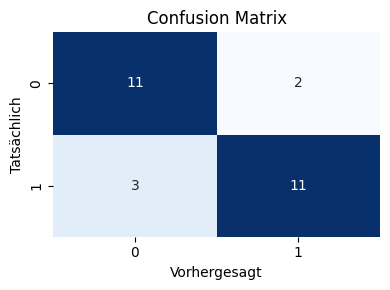

In [13]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, log_loss
)

# Vorhersagen und Wahrscheinlichkeiten
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

# Wahre Labels
y_true = y_test["target"]

# Metriken berechnen
print(f"Final BCE Loss: {log_loss(y_true, y_prob):.4f}")
print(f"Accuracy:  {accuracy_score(y_true, y_pred):.2f}")
print(f"Precision: {precision_score(y_true, y_pred):.2f}")
print(f"Recall:    {recall_score(y_true, y_pred):.2f}")
print(f"F1-Score:  {f1_score(y_true, y_pred):.2f}")

# Confusion Matrix anzeigen
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Vorhergesagt")
plt.ylabel("Tatsächlich")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


In [14]:
### Überprüft eure Lösung
from scripts.checker import check_metrics
check_metrics(y_true, y_pred, y_prob)

✅ Accuracy: 0.81
✅ Precision: 0.85
✅ Recall: 0.79
✅ F1-Score: 0.81


## Aufgabe 6: Scatterplot der Vorhersagen

Visualisiere die Modellvorhersagen mithilfe eines Scatterplots:

Verändere schrittweise **ein einzelnes Feature** (z. B. die **Normalkraft**) und beobachte, wie sich die **Vorhersagewahrscheinlichkeit** des Modells ändert – während alle anderen Features konstant gehalten werden.

### Schritte:

1. **Wähle ein einzelnes Datenbeispiel** aus dem Testdatensatz, z. B. `X_test.iloc[0]`
2. **Wähle ein numerisches Feature**, z. B. `"Normalkraft"`
3. Erstelle eine Kopie des Datenpunkts und **verändere das gewählte Feature** in kleinen Schritten (z. B. von -2 bis +2 in Standardskalierung).
4. Lass für jede Variante des Datenpunkts das Modell eine Vorhersagewahrscheinlichkeit berechnen.
5. Erstelle ein **Scatterplot**, der den Featurewert (auf normal skalierten Achsen -> Rücktransformation!) gegen die vorhergesagte Wahrscheinlichkeit zeigt.

### Plot:

* x-Achse: Geänderter Wert des gewählten Features (z. B. Normalkraft)
* y-Achse: Vorhersagewahrscheinlichkeit für `target = 1`

### Interpretation (Reflexion):

Beantworte folgende Fragen:

* Wie stark beeinflusst das Feature die Vorhersage?
* Welche Feature-Werte führen zu einer besonders hohen bzw. niedrigen Wahrscheinlichkeit?
* Wie steil ist der Anstieg? Was sagt das über den Einfluss des Features aus?
* Was bedeutet das im Kontext des Problems (z. B. hohe Normalkraft = geringeres Risiko)?

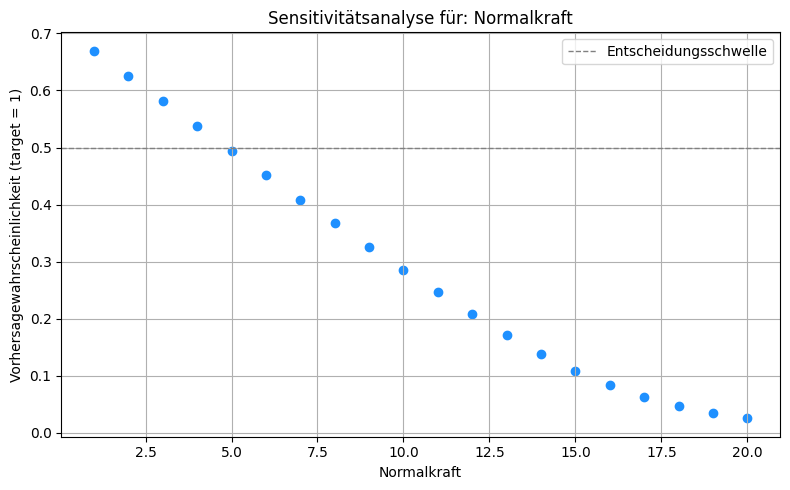

In [15]:
liste = list()
columns = ['Normalkraft', 'Frequenz', 'Bewegungshub', 'Beschichtung_Ag_Sn_Nein', 'Zwischenschicht_Ni_Nein']

for i in range(10):
    # 1. Wähle ein Testbeispiel
    x_original = X_test.iloc[i].copy()

    # 2. Wähle ein Feature
    feature_name = "Normalkraft"

    # 3. Erzeuge veränderte Varianten des Datenpunkts
    feature_values = np.linspace(X_processed[feature_name].min(), X_processed[feature_name].max(), 20)  # standardisierte Skala
    probs = []

    # Alle anderen Werte konstant halten
    for val in feature_values:
        x_modified = x_original.copy()
        x_modified[feature_name] = val
        # Modell erwartet 2D-Array mit float-Werten (auch für bools)
        prob = model.predict_proba(pd.DataFrame([x_modified.values], columns=X_test.columns))[0, 1]
        probs.append(prob)
        
    liste.append(probs)

# Rücktransformation von standardisiert auf Originalskala
original_values = scaler.inverse_transform(
    np.column_stack([
        np.full_like(feature_values, x_original["Normalkraft"]) if feature_name != "Normalkraft" else feature_values,
        np.full_like(feature_values, x_original["Frequenz"]) if feature_name != "Frequenz" else feature_values,
        np.full_like(feature_values, x_original["Bewegungshub"]) if feature_name != "Bewegungshub" else feature_values,
        np.full_like(feature_values, x_original["Beschichtung_Ag_Sn_Nein"]) if feature_name != "Beschichtung_Ag_Sn_Nein" else feature_values,
        np.full_like(feature_values, x_original["Zwischenschicht_Ni_Nein"]) if feature_name != "Zwischenschicht_Ni_Nein" else feature_values,
    ])
)[:, columns.index(feature_name)]

probs = np.array([liste]).mean(axis = 1)

# 4. Plot
plt.figure(figsize=(8, 5))
plt.scatter(original_values, probs[0,:], color='dodgerblue')
plt.xlabel(f"{feature_name}")
plt.ylabel("Vorhersagewahrscheinlichkeit (target = 1)")
plt.title(f"Sensitivitätsanalyse für: {feature_name}")
plt.grid(True)
plt.axhline(0.5, color="gray", linestyle="--", linewidth=1, label="Entscheidungsschwelle")
plt.legend()
plt.tight_layout()
plt.show()


## Aufgabe 7: Interpretation der Feature-Gewichte

Nutze die Koeffizienten des Modells, um zu verstehen, welche Features das Modell beeinflussen.

Schritte:
1. Erstelle ein DataFrame, das die Features (`X_prepared.columns`) den zugehörigen Koeffizienten (`model.coef_`) gegenüberstellt.
2. Sortiere es nach der Stärke des Einflusses (betraglich).
3. Stelle die wichtigsten Features in einem Balkendiagramm dar.

Beantworte folgende Fragen:

1. **Was bedeutet ein hoher positiver Wert eines Gewichts in Bezug auf die Vorhersagewahrscheinlichkeit für einen Defekt?**
   → Was sagt z. B. ein hohes Gewicht für das Feature „Bewegungshub“ über dessen Einfluss auf die Wahrscheinlichkeit eines Defekts aus?
2. **Was sagt ein negatives Gewicht eines Features über dessen Einfluss aus?**
3. **Welche Features haben den größten Einfluss auf die Vorhersageentscheidung des Modells?**
   → Schaut euch die Top 3 (nach Betrag des Gewichts) an: Sind das physikalisch plausible Einflussfaktoren?
4. **Welche Features erscheinen weniger relevant (nahe bei 0)?**
   → Könnte das auf Redundanz oder irrelevante Informationen hindeuten?

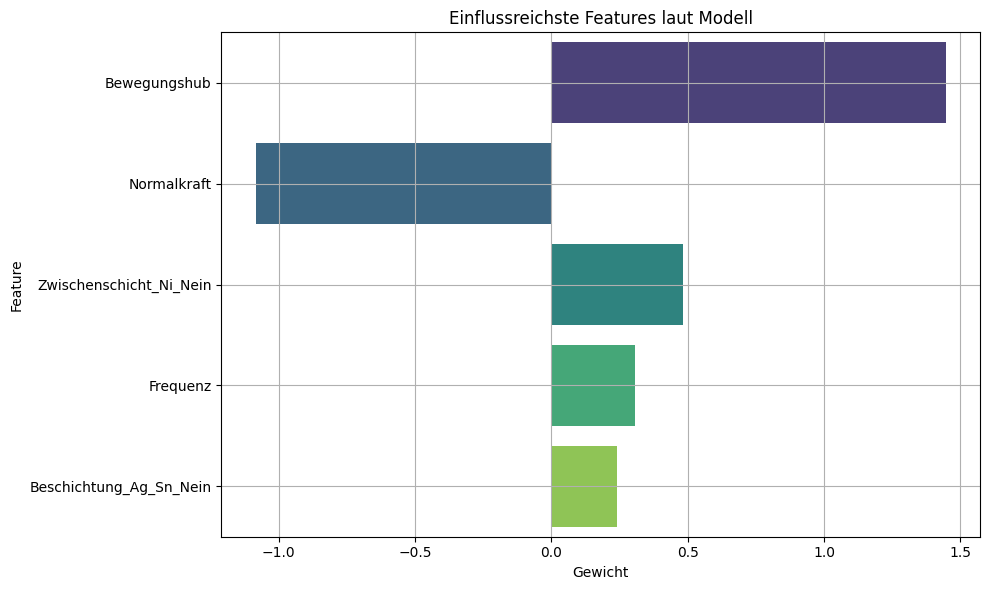

In [16]:
# Feature-Namen und Koeffizienten
coefficients = model.coef_[0]
feature_names = X_processed.columns

# DataFrame erstellen
coef_df = pd.DataFrame({
    "Feature": feature_names,
    "Gewicht": coefficients
})

# Nach absolutem Einfluss sortieren
coef_df["AbsGewicht"] = coef_df["Gewicht"].abs()
coef_df_sorted = coef_df.sort_values("AbsGewicht", ascending=False)

# Visualisierung
plt.figure(figsize=(10, 6))
sns.barplot(data=coef_df_sorted.head(10), x="Gewicht", y="Feature", palette="viridis", hue = coef_df_sorted.head(10)['Feature'], legend=False)
plt.title("Einflussreichste Features laut Modell")
plt.grid(True)
plt.tight_layout()
plt.show()


## Aufgabe 8: Lineare Regression
Ihr trainiert nun ein **lineares Regressionsmodell** auf den Daten der **defekten Verbindungen**, um vorherzusagen, wann eine Verbindung voraussichtlich versagt. Die Zielvariable ist die Zyklenzahl bei 300 mOhm. Diese Größe an sich ist für echte Anwendungen nicht wirklich aussagekräftig, allerdings lässt sich die Zyklenzahl bei periodischer Belastung mit einer bestimmten Zeit identifizieren, bei der die Verbindung versagt. Sie ist also einfach eine Näherungsvariable, die ein Gefühl für die Zeit bis zum Versagen der Verbindung unter bestimmten Voraussetzungen liefert.

* Benutze die bereits gesplitteten Variablen `X_train` `y_train`, `X_test` und `y_test`, und filtere sie so, dass nur Steckverbindungen enthalten sind, die die 300 mΩ-Grenze **erreicht haben**.
* Speichere diese DataFrames mit dem Zusatz `_linreg`.
* Verwende dieselben Eingabefeatures wie für die Klassifikation.
* Die Zielvariable ist jetzt `Zyklus_bei_300_mOhm`.

In [17]:
# 1. Defekte Fälle filtern
X_train_linreg = X_train[y_train["target"] == 1]
y_train_linreg = y_train.loc[y_train["target"] == 1, "Zyklus_bei_300_mOhm"]
X_test_linreg = X_test[y_test["target"] == 1]
y_test_linreg = y_test.loc[y_test["target"] == 1, "Zyklus_bei_300_mOhm"]

### 9. **Regressionsmodell trainieren**

* Trainiere das Regressionsmodell (`LinearRegression`) auf den vorbereiteten Trainingsdaten.
* Ziel: Vorhersage der Zyklenanzahl, bei der die 300 mΩ-Grenze erreicht wird.

In [18]:
from sklearn.linear_model import LinearRegression

reg_model = LinearRegression()
reg_model.fit(X_train_linreg, y_train_linreg)
y_pred_linreg = reg_model.predict(X_test_linreg)


### 10. **Modell evaluieren**

Berechne die folgenden Regressionsmetriken:

* MAE (Mean Absolute Error)
* MSE (Mean Squared Error)
* RMSE (Root Mean Squared Error)
* R² (Bestimmtheitsmaß)

In [19]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(y_test_linreg, y_pred_linreg)
mse = mean_squared_error(y_test_linreg, y_pred_linreg)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_linreg, y_pred_linreg)

print("R²:", r2)
print("MSE:", mse)
print("MAE:", mae)
print("RMSE:", rmse)


R²: 0.6580749759393751
MSE: 130200104.27922283
MAE: 8966.895427270394
RMSE: 11410.52602990865


### 11. **Scatterplot der Vorhersagen**

Vergleiche die Modellvorhersagen mit den tatsächlichen Werten in einem Scatterplot.

1. Erstelle einen Scatterplot mit den Testdaten:
   * x-Achse: vorhergesagte Werte
   * y-Achse: echte Zielwerte
   * Farbe (`hue` in seaborn): z. B. `Normalkraft` oder `Frequenz`, um Trends zu erkennen
   * Markiere die Idealdiagonale (y = x) zur Orientierung.

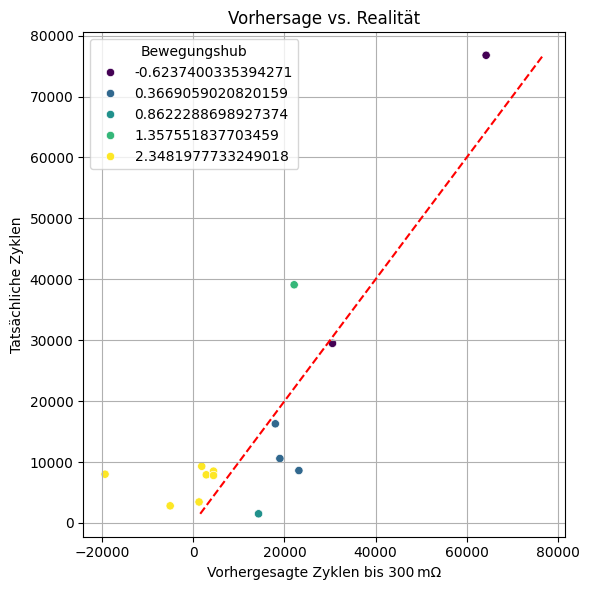

In [20]:
df_plot = pd.DataFrame({
    "y_true": y_test_linreg,
    "y_pred": y_pred_linreg,
    "Bewegungshub": X_test_linreg["Bewegungshub"].values
})

plt.figure(figsize=(6, 6))
sns.scatterplot(data=df_plot, x="y_pred", y="y_true", hue="Bewegungshub", palette="viridis")
plt.plot([df_plot.y_true.min(), df_plot.y_true.max()], [df_plot.y_true.min(), df_plot.y_true.max()], 'r--')
plt.xlabel("Vorhergesagte Zyklen bis 300 mΩ")
plt.ylabel("Tatsächliche Zyklen")
plt.title("Vorhersage vs. Realität")
plt.grid(True)
plt.tight_layout()
plt.show()


### 12. **Interpretation der Regressionsgewichte**

Du hast ein lineares Regressionsmodell trainiert, das vorhersagt, **nach wie vielen Zyklen** die Schwelle von 300 mΩ überschritten wird (nur für Steckverbindungen, die tatsächlich defekt wurden). Visualisiere die Koeffizienten des trainierten Regressionsmodells wie bei der Klassifikation. Also:
1. Erstelle ein DataFrame, das die Features (`X_prepared.columns`) den zugehörigen Koeffizienten (`reg_model.coef_`) gegenüberstellt.
2. Sortiere es nach der Stärke des Einflusses (betraglich).
3. Stelle die wichtigsten Features in einem Balkendiagramm dar.

Interpretiere die Modellgewichte. Nutze dabei die folgenden Leitfragen:

1. **Allgemeines Verständnis**
   a. Was bedeutet ein negativer bzw. ein positiver Koeffizient in diesem Modell? (Hinweis: Nutze die Formel für die Vorhersage bei der linearen Regression).
   b. Was sagt z. B. der negative Wert für „Normalkraft“ über die Lebensdauer aus?

2. **Vergleich zur Klassifikation**
   a. Stimmen die Tendenzen mit den Ergebnissen der Klassifikation überein?
   b. Gibt es Features, deren Einfluss im Regressionsmodell **anders** aussieht als im Klassifikationsmodell?

3. **Fokus auf die Beschichtung**
   a. Das Modell sagt, dass „**ohne Beschichtung**“ zu längerer Lebensdauer führt. Ist das intuitiv?
   b. Wie könnte dieser Effekt durch die Datenverteilung entstehen?
   c. Wie würdest du überprüfen, ob dieser Effekt ein Artefakt ist?

4. **Diskussion der Einschränkungen**
   a. Auf welchen Teil der Daten wurde das Regressionsmodell trainiert?
   b. Warum kann das zu anderen Schlussfolgerungen führen als bei der Klassifikation?

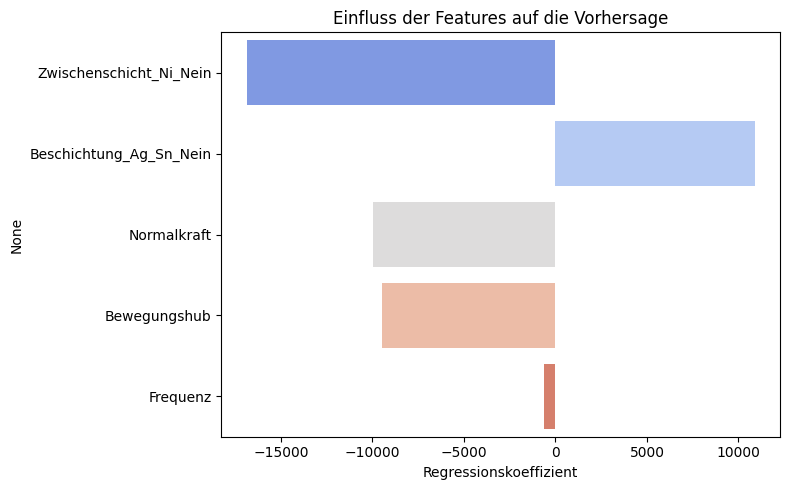

Column: Normalkraft -9991.762720962319
Column: Frequenz -603.8043392917516
Column: Bewegungshub -9460.45566960381
Column: Beschichtung_Ag_Sn_Nein 10881.002020177408
Column: Zwischenschicht_Ni_Nein -16862.693037480567


In [ ]:
coefs = pd.Series(reg_model.coef_, index=X_train_linreg.columns).sort_values(key=np.abs, ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(x=coefs.values, y=coefs.index, palette="coolwarm", hue = coefs.index, legend=False)
plt.title("Einfluss der Features auf die Vorhersage")
plt.xlabel("Regressionskoeffizient")
plt.tight_layout()
plt.show()
